In [569]:
import numpy as np
import matplotlib.pyplot as plt

In [570]:
# Constants
hbar = 1.0   # Planck's constant / 2π
m = .1
delta = -2.5E-8
k = 1E-4
kprime_nu = k*np.sqrt(1+2*delta)
kprime_antinu = k*np.sqrt(1-2*delta)
distance = 3E13*5
earth_cutoff = 3E13 / distance

# Solving the TISE for equation (11) in Saarik's paper
# ignoring spherical Bessel nonsense for now
# Should be able to just graph it in 1D to see if I can it to work, then it should be relatively simple to multiply this by
# spherical Bessel stuff with theta and phi dependence to extend to 3D


# delta negative is neutrino, delta positive is anti-neutrino

In [571]:
# define derivative matrices
def first_deriv(N, distance):
    diags0 = np.zeros(N)

    ddr = np.diag(diags0)

    for i in range(0, ddr.shape[0]):
        if i != 0:
            ddr[i,i-1] = -1
        if i != ddr.shape[0]-1:
            ddr[i,i+1] = 1
    
    delta_x = distance / N

    return ddr / (2 * delta_x)



def second_deriv(N, distance):
    diags2 = np.full(N, 2)

    d2dr = np.diag(diags2)

    for i in range(0, d2dr.shape[0]):
        if i != 0:
            d2dr[i,i-1] = -1
        if i != d2dr.shape[0]-1:
            d2dr[i,i+1] = -1
    
    delta_x = distance / N

    return d2dr / (delta_x**2)


In [572]:
# define the potentials, treating it for now as a 1D step function


def potential_nu(N, r, l):

    H = np.zeros((N,N))
    for i in range(0, H.shape[0]):
        #try just a step function
        
        # inside the earth:
        # it's plus delta because -mU = + delta/k^2
        V_eff_in = kprime_nu**2 + 2 * delta * kprime_nu**2 - (l * (l + 1))/(r[i]**2)

        # outside the earth:
        V_eff_out = k**2 * (1  - (l * (l + 1))/(k**2 * r[i]**2))


        # if i < 3:
        #     H[i,i] = 1E20        
        # el
        if i < int(earth_cutoff * N):
            H[i,i] = V_eff_in
            #print("V_eff_in: ", V_eff_in)
        else:
            H[i,i] = V_eff_out
            #print("V_eff_out: ", V_eff_out)
    #print("nu: \n",H)

    return H



def potential_antinu(N, r, l):

    H = np.zeros((N,N))
    for i in range(0, H.shape[0]):
        #try just a step function
        global V_eff_in_neg, V_eff_out_neg
        # inside the earth:
        V_eff_in_neg = kprime_antinu**2 - 2 * delta  * kprime_antinu**2 - (l * (l + 1))/(r[i]**2)

        # outside the earth:
        V_eff_out_neg = k**2 * (1  - (l * (l + 1))/(k**2 * r[i]**2))

        # if i < 3:
        #     H[i,i] = 1E20
        # el
        if i < int(earth_cutoff * N):
            H[i,i] = V_eff_in_neg
            #print("V_eff_in_neg: ", V_eff_in_neg)
        else:
            H[i,i] = V_eff_out_neg
            #print("V_eff_out_neg: ", V_eff_out_neg)
    #print("antinu: \n",H)
    return H

potential_nu(1000, np.linspace(.01, distance, 1000), 10)
potential_antinu(1000, np.linspace(.01, distance, 1000), 1E10)

array([[-1.00000000e+24,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -4.43555000e-03,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00, -1.10888000e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         5.53770640e-09,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  5.54664439e-09,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  5.55555556e-09]])

In [573]:
# create the equation to be solved
def Hamiltonian_nu(N, r, l):
    H = second_deriv(N, distance) +  (2/r) * first_deriv(N, distance) + potential_nu(N,r, l)
    return H

def Hamiltonian_antinu(N, r, l):
    H = second_deriv(N, distance) + (2/r) *  first_deriv(N, distance) + potential_antinu(N,r, l)
    return H

def normalize(psi):
    norm = np.sqrt(np.sum(np.abs(psi)**2, axis=1))  # Compute the norm of each row
    psi_norm = psi / norm[:, np.newaxis]  # Normalize each row
    return psi_norm


-1099999.99999999
-1099999.99999999
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.

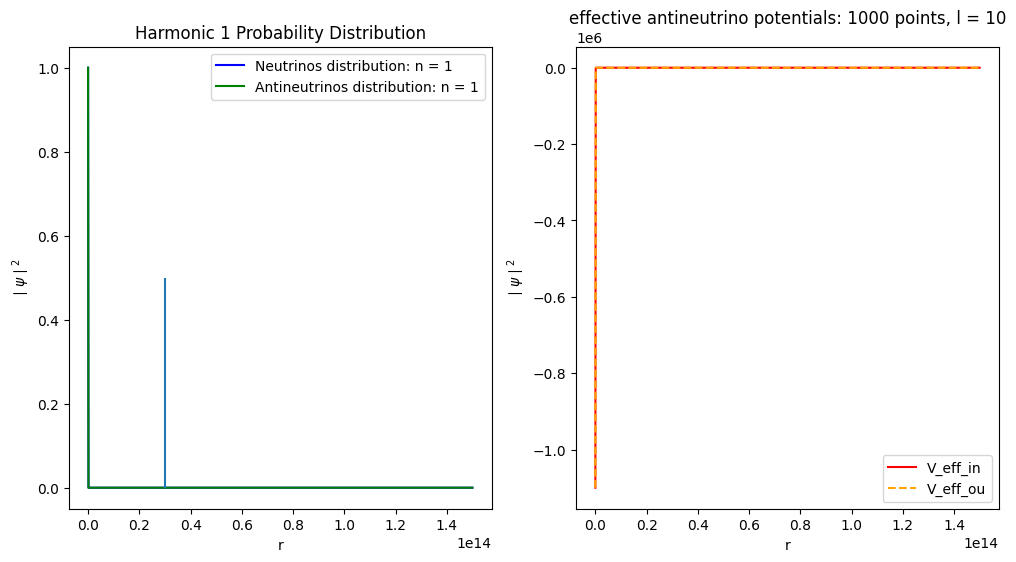

In [574]:
# function to graph the nth harmonic
#try solving equation 25 instead

# fix my 2mU to delta definition - it's wrong (tried fixing it make sure its right)

def harmonic(n, N, l):
    
    global r_values, psi_antinu, psi_nu
    
    r_values = np.linspace(.01, distance, N)
    #might try using eig instead of eigh because the matrices are no longer symmetric
    E_pos, psi_nu = np.linalg.eig(potential_nu(N, r_values, l))
    E_neg, psi_antinu = np.linalg.eig(potential_antinu(N, r_values, l))
    print(E_pos[0])
    print(E_neg[0])

    psi_nu = psi_nu.T
    psi_antinu = psi_antinu.T
    print(psi_nu[0])

    # Create two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the first two graphs on the first subplot
    ax1.plot(r_values, np.abs(psi_nu[n-1])**2, color = 'blue', label=f'Neutrinos distribution: n = {n}') # graphing numerically
    ax1.plot(r_values, np.abs(psi_antinu[n-1])**2, color = 'green', label=f'Antineutrinos distribution: n = {n}') # graphing numerically

    asymmetry = (np.abs(psi_nu[n-1])**2 - np.abs(psi_antinu[n-1])**2)# / (np.abs(psi_nu[n-1])**2 + np.abs(psi_antinu[n-1])**2)
    print("Asymmetry;", asymmetry)
    

    # Plot the asymmetry on the second subplot
    ax2.plot(r_values, kprime_antinu**2 * (1 - 2 * delta - (l * (l + 1))/(kprime_antinu**2 * r_values**2)), color='red', label='V_eff_in') # graphing numerically
    ax2.plot(r_values, k**2 * (1  - (l * (l + 1))/(k**2 * r_values**2)), color='orange', label='V_eff_ou', linestyle = '--') # graphing numerically
    
    # graph the potential on the same plot
    ax1.vlines(3E13, ymin = 0, ymax=.5)
    #ax2.vlines(3E13, ymin = 0, ymax=1)

    # Set labels and title for the first subplot
    ax1.set_xlabel('r')
    ax1.set_ylabel(r'$\mid\psi\mid^2$')
    ax1.set_yscale('linear')
    ax1.set_xscale('linear')
    ax1.set_title(f'Harmonic {n} Probability Distribution')

    # Set labels and title for the second subplot
    ax2.set_xlabel('r')
    ax2.set_ylabel(r'$\mid\psi\mid^2$')
    ax2.set_yscale('linear')
    ax2.set_xscale('linear')
    ax2.set_title(f'effective antineutrino potentials: {N} points, l = {l}')

    # Display legend
    ax1.legend()
    ax2.legend()

    # Save the figure
    plt.savefig('1D_plots/step_function.png')

    # Show the plot
    plt.show()



# harmonic(1, 4000, l=1E8)
harmonic(1, 1000, l=10)
# harmonic(1, 4000, l=1E12)
# harmonic(1, 5000, l=1E8)
# harmonic(1, 5000, l=1E10)
# harmonic(1, 5000, l=1E12)
# harmonic(1, 6000, l=1E8)
# harmonic(1, 6000, l=1E10)
# harmonic(1, 6000, l=1E12)

In [575]:
# Potentials and Hamiltonian from equation 25


def potential_nu_25(N, r, l):

    H = np.zeros((N,N))
    for i in range(0, H.shape[0]):
        #try just a step function
        
        # inside the earth:
        # it's plus delta because -mU = + delta/k^2
        V_eff_in = (l * (l + 1))/(r[i]**2) + 2 * delta * kprime_nu**2

        # outside the earth:
        V_eff_out = (l * (l + 1))/(r[i]**2)

        if i < int(earth_cutoff * N):
            H[i,i] = V_eff_in
        else:
            H[i,i] = V_eff_out

    return H

def potential_antinu_25(N, r, l):

    H = np.zeros((N,N))
    for i in range(0, H.shape[0]):
        #try just a step function
        
        # inside the earth:
        V_eff_in_neg = (l * (l + 1))/(r[i]**2) - 2 * delta * kprime_antinu**2

        # outside the earth:
        V_eff_out_neg = (l * (l + 1))/(r[i]**2)
        #print("In, Out neg: ", V_eff_in_neg, V_eff_out_neg)

        if i < int(earth_cutoff * N):
            H[i,i] = V_eff_in_neg
        else:
            H[i,i] = V_eff_out_neg

    return H

# create the equation to be solved
def Hamiltonian_nu_25(N, r, l):
    H = - second_deriv(N, distance) + potential_nu_25(N,r, l)
    return H

def Hamiltonian_antinu_25(N, r, l):
    H = - second_deriv(N, distance) + potential_antinu_25(N,r, l)
    return H


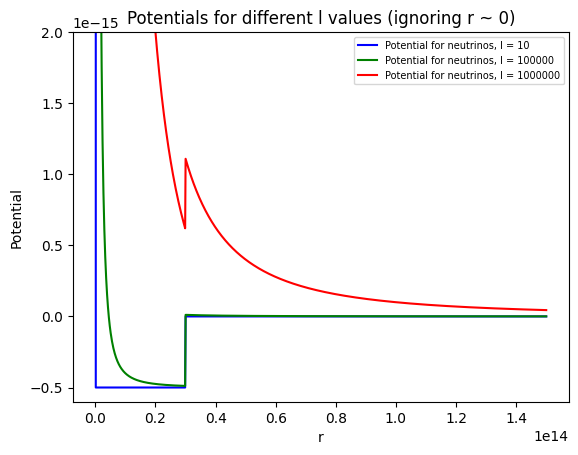

In [576]:
def plot_potentials(N, l_values):
    
    global r_values
    
    r_values = np.linspace(0.001, distance, N)
    
    # Create a list of colors for the different l values
    colors = ['blue', 'green', 'red', 'purple', 'orange']

    for i, l in enumerate(l_values):
        # Calculate the potential matrices
        potential_nu = Hamiltonian_nu_25(N, r_values, l)
        potential_antinu = Hamiltonian_antinu_25(N, r_values, l)

        # Extract the diagonal values
        V_nu = np.diag(potential_nu)
        V_antinu = np.diag(potential_antinu)

        # Plot the potentials
        plt.plot(r_values, V_nu, color=colors[i], label=f'Potential for neutrinos, l = {l}')
        #plt.plot(r_values, V_antinu, color=colors[i], linestyle='dashed', label=f'Potential for antineutrinos, l = {l}')

    plt.xlabel('r')
    plt.ylabel('Potential')
    plt.yscale('linear')
    plt.ylim(-.6E-15, 2E-15)
    plt.title('Potentials for different l values (ignoring r ~ 0)')
    
    # Adjust legend size and position
    plt.legend(fontsize=7, loc='upper right')

    plt.savefig('1D_plots/potentials.png')
    plt.show()

# Call the function with a list of l values
plot_potentials(1000, [10, 100000, 1000000])

In [577]:
# function to graph the nth harmonic
#try solving equation 25 instead

# fix my 2mU to delta definition - it's wrong (tried fixing it make sure its right)

def harmonic(n, N, l):
    
    global r_values, psi_antinu, psi_nu
    
    r_values = np.linspace(0.001, distance, N)
    E_pos, psi_nu = np.linalg.eigh(Hamiltonian_nu_25(N, r_values, l))
    E_neg, psi_antinu = np.linalg.eigh(Hamiltonian_antinu_25(N, r_values, l))
    psi_nu = psi_nu.T
    psi_antinu = psi_antinu.T

    # Create two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the first two graphs on the first subplot
    # divide by r_values bc equation 25 defines phi = r*psi
    #Calculate the integral of the absolute square of psi/r over all space
    norm_nu = np.trapz(np.abs(psi_nu[n-1] / r_values)**2, r_values)
    norm_antinu = np.trapz(np.abs(psi_antinu[n-1] / r_values)**2, r_values)

    # Divide psi by the square root of this integral to renormalize
    psi_nu_normalized = psi_nu[n-1] / np.sqrt(norm_nu)
    psi_antinu_normalized = psi_antinu[n-1] / np.sqrt(norm_antinu)


    # Now plot the normalized functions
    ax1.plot(r_values, np.abs(psi_nu_normalized / r_values)**2, color = 'blue', label=f'Potential for neutrinos: n = {n}')
    ax1.plot(r_values, np.abs(psi_antinu_normalized / r_values)**2, color = 'green', label=f'Potential antineutrinos: n = {n}')

    # ax1.plot(r_values, np.abs(psi_pos[n-1] / r_values)**2, color = 'blue', label=f'Potential unchanged: n = {n}')
    # ax1.plot(r_values, np.abs(psi_neg[n-1] / r_values)**2, color = 'green', label=f'Potential negative: n = {n}')


    # Plot the asymmetry on the second subplot
    asym = []
    for i in range(0, len(r_values)):
        if np.abs(psi_nu_normalized[i] / r_values[i])**2 == np.abs(psi_antinu_normalized[i] / r_values[i])**2 and np.abs(psi_nu_normalized[i] / r_values[i])**2 == 0:
            asym.append(0)
        else:
            asym.append((np.abs(psi_nu_normalized[i] / r_values[i])**2 - np.abs(psi_antinu_normalized[i] / r_values[i])**2)/(np.abs(psi_nu_normalized[i] / r_values[i])**2 + np.abs(psi_antinu_normalized[i] / r_values[i])**2))
    ax2.plot(r_values, asym, color='red', label='Asymmetry') # graphing numerically
    
    # graph the potential on the same plot
    #ax1.vlines(3E13, ymin = 0, ymax=.001)
    #ax2.vlines(3E13, ymin = 0, ymax=1)

    # Set labels and title for the first subplot
    ax1.set_xlabel('r')
    ax1.set_ylabel(r'$\mid\psi\mid^2$')
    ax1.set_yscale('linear')
    ax1.set_xscale('linear')
    ax1.set_title(f'Harmonic {n} Probability Distribution')

    # Set labels and title for the second subplot
    ax2.set_xlabel('r')
    ax2.set_ylabel(r'$\mid\psi\mid^2$')
    ax2.set_yscale('linear')
    ax2.set_xscale('linear')
    ax2.set_title(f'Asymmetry: {N} points, l = {l}')

    # Display legend
    ax1.legend()
    ax2.legend()

    # Save the figure
    plt.savefig('1D_plots/step_function.png')

    # Show the plot
    plt.show()


harmonic(1, 4000, l=10)


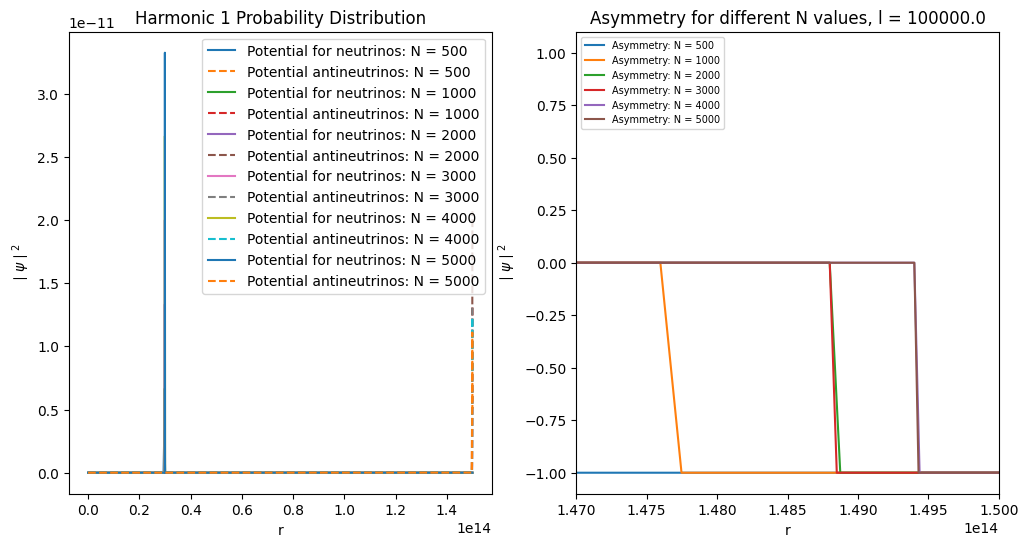

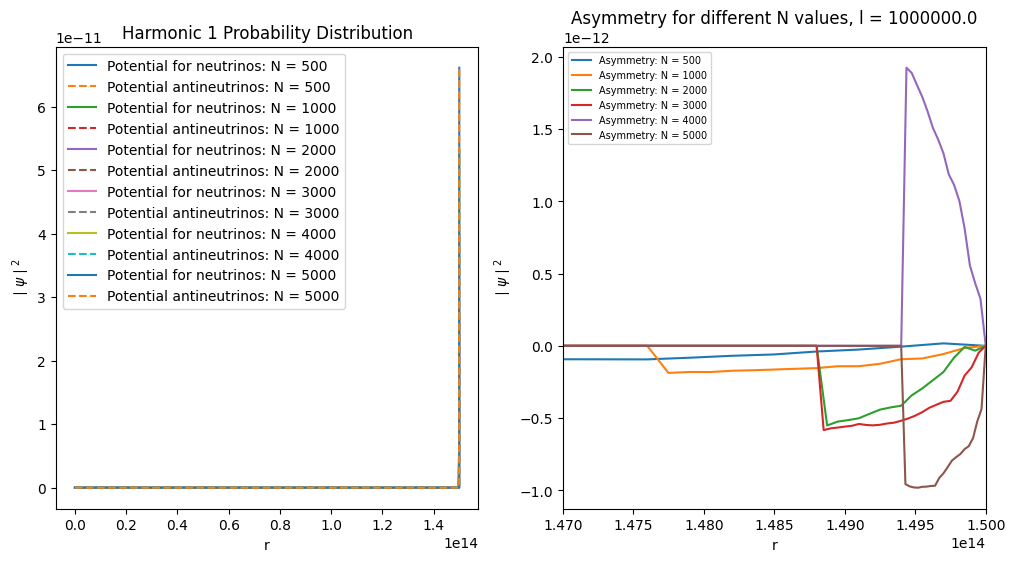

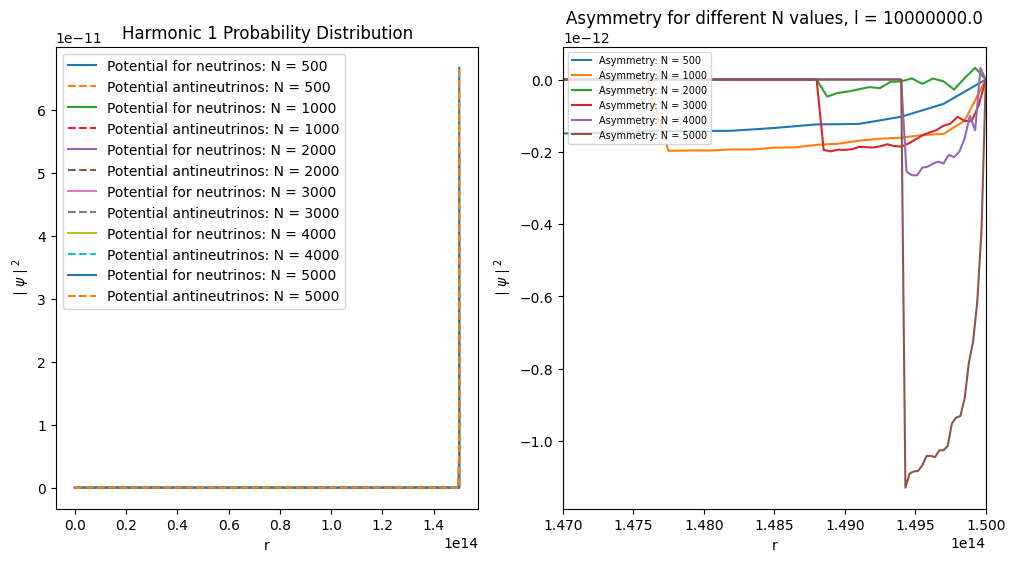

In [ ]:
def harmonic(n, N_values, l):
    
    global r_values, psi_antinu, psi_nu
    

    # Create two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    asym = []

    for i, N in enumerate(N_values):
        r_values = np.linspace(0.001, distance, N)
        E_pos, psi_nu = np.linalg.eigh(Hamiltonian_nu_25(N, r_values, l))
        E_neg, psi_antinu = np.linalg.eigh(Hamiltonian_antinu_25(N, r_values, l))
        psi_nu = psi_nu.T
        psi_antinu = psi_antinu.T

        #Calculate the integral of the absolute square of psi/r over all space
        norm_nu = np.trapz(np.abs(psi_nu[n-1] / r_values)**2, r_values)
        norm_antinu = np.trapz(np.abs(psi_antinu[n-1] / r_values)**2, r_values)

        # Divide psi by the square root of this integral to renormalize
        psi_nu_normalized = psi_nu[n-1] / np.sqrt(norm_nu)
        psi_antinu_normalized = psi_antinu[n-1] / np.sqrt(norm_antinu)

        # Now plot the normalized functions
        ax1.plot(r_values, np.abs(psi_nu_normalized / r_values)**2, label=f'Potential for neutrinos: N = {N}')
        ax1.plot(r_values, np.abs(psi_antinu_normalized / r_values)**2,  linestyle='dashed', label=f'Potential antineutrinos: N = {N}')

        # Plot the asymmetry on the second subplot, defined as such to prevent dividing by zero
        asym = []
        for j in range(0, len(r_values)):
            if np.abs(psi_nu_normalized[j] / r_values[j])**2 == np.abs(psi_antinu_normalized[j] / r_values[j])**2 and np.abs(psi_nu_normalized[j] / r_values[j])**2 == 0:
                asym.append(0)
            else:
                asym.append((np.abs(psi_nu_normalized[j] / r_values[j])**2 - np.abs(psi_antinu_normalized[j] / r_values[j])**2)/(np.abs(psi_nu_normalized[j] / r_values[j])**2 + np.abs(psi_antinu_normalized[j] / r_values[j])**2))
        ax2.plot(r_values, asym, label=f'Asymmetry: N = {N}') # graphing numerically

    # Set labels and title for the first subplot
    ax1.set_xlabel('r')
    ax1.set_ylabel(r'$\mid\psi\mid^2$')
    ax1.set_yscale('linear')
    ax1.set_xscale('linear')
    ax1.set_title(f'Harmonic {n} Probability Distribution')

    # Set labels and title for the second subplot
    ax2.set_xlabel('r')
    ax2.set_ylabel(r'$\mid\psi\mid^2$')
    ax2.set_yscale('linear')
    ax2.set_xscale('linear')
    ax2.set_xlim(1.47E14, distance)
    ax2.set_title(f'Asymmetry for different N values, l = {l}')

    # Display legend
    ax1.legend()
    ax2.legend(fontsize = 7, loc = 'upper left')

    # Save the figure
    plt.savefig('1D_plots/step_function.png')

    # Show the plot
    plt.show()

# Call the function with a list of N values
harmonic(1, [500, 1000, 2000, 3000, 4000, 5000], 1e5)
harmonic(1, [500, 1000, 2000, 3000, 4000, 5000], 1e6)
harmonic(1, [500, 1000, 2000, 3000, 4000, 5000], 1e7)

100.0 l values remaining
99.0 l values remaining
98.0 l values remaining
97.0 l values remaining
96.0 l values remaining
95.0 l values remaining
94.0 l values remaining
93.0 l values remaining
92.0 l values remaining
91.0 l values remaining
90.0 l values remaining
89.0 l values remaining
88.0 l values remaining
87.0 l values remaining
86.0 l values remaining
85.0 l values remaining
84.0 l values remaining
83.0 l values remaining
82.0 l values remaining
81.0 l values remaining
80.0 l values remaining
79.0 l values remaining
78.0 l values remaining
77.0 l values remaining
76.0 l values remaining
75.0 l values remaining
74.0 l values remaining
73.0 l values remaining
72.0 l values remaining
71.0 l values remaining
70.0 l values remaining
69.0 l values remaining
68.0 l values remaining
67.0 l values remaining
66.0 l values remaining
65.0 l values remaining
64.0 l values remaining
63.0 l values remaining
62.0 l values remaining
61.0 l values remaining
60.0 l values remaining
59.0 l values r

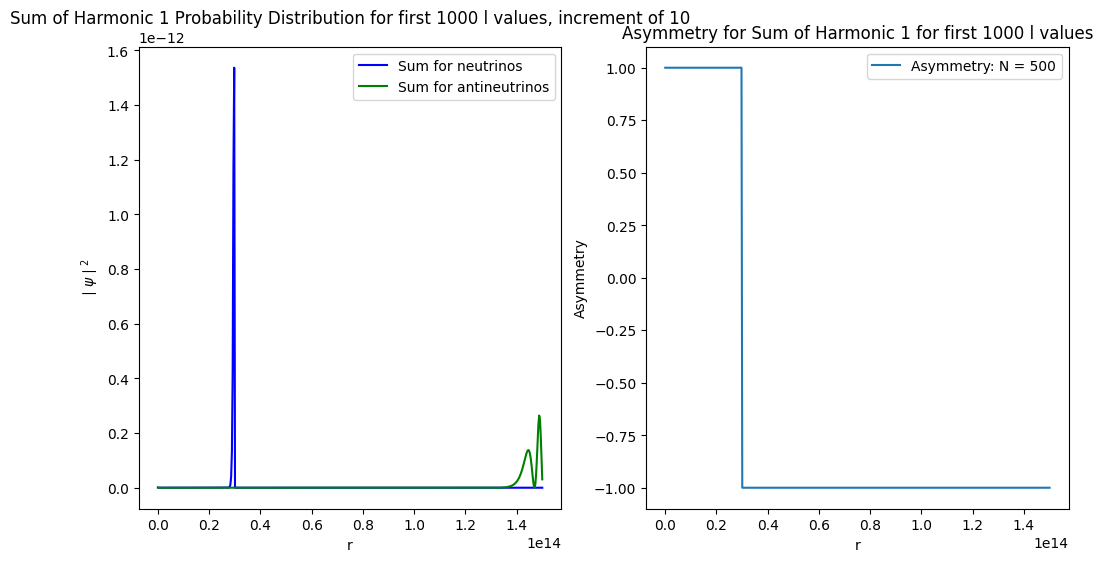

In [ ]:
def harmonic_sum(n, N, l_max, increment):
    
    global r_values, psi_antinu, psi_nu
    
    r_values = np.linspace(0.001, distance, N)
    
    # Initialize sum arrays
    sum_psi_nu = np.zeros_like(r_values)
    sum_psi_antinu = np.zeros_like(r_values)

    for l in range(0, l_max, increment):  # loop over l values in a given increment
        print(f'{(l_max - l)/increment} l values remaining')
        E_pos, psi_nu = np.linalg.eigh(Hamiltonian_nu_25(N, r_values, l))
        E_neg, psi_antinu = np.linalg.eigh(Hamiltonian_antinu_25(N, r_values, l))
        psi_nu = psi_nu.T
        psi_antinu = psi_antinu.T

        norm_nu = np.trapz(np.abs(psi_nu[n-1] / r_values)**2, r_values)
        norm_antinu = np.trapz(np.abs(psi_antinu[n-1] / r_values)**2, r_values)

        psi_nu_normalized = psi_nu[n-1] / np.sqrt(norm_nu)
        psi_antinu_normalized = psi_antinu[n-1] / np.sqrt(norm_antinu)

        # Add the normalized wavefunctions to the sum
        sum_psi_nu += psi_nu_normalized
        sum_psi_antinu += psi_antinu_normalized

    # Normalize the sum
    norm_sum_nu = np.trapz(np.abs(sum_psi_nu / r_values)**2, r_values)
    norm_sum_antinu = np.trapz(np.abs(sum_psi_antinu / r_values)**2, r_values)

    sum_psi_nu_normalized = sum_psi_nu / np.sqrt(norm_sum_nu)
    sum_psi_antinu_normalized = sum_psi_antinu / np.sqrt(norm_sum_antinu)

    # Create two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the sum of the normalized wavefunctions
    ax1.plot(r_values, np.abs(sum_psi_nu_normalized / r_values)**2, color = 'blue', label='Sum for neutrinos')
    ax1.plot(r_values, np.abs(sum_psi_antinu_normalized / r_values)**2, color = 'green', label='Sum for antineutrinos')

    # Plot the asymmetry
    asym = []
    for j in range(0, len(r_values)):
        if np.abs(sum_psi_nu_normalized[j] / r_values[j])**2 == np.abs(sum_psi_antinu_normalized[j] / r_values[j])**2 and np.abs(sum_psi_nu_normalized[j] / r_values[j])**2 == 0:
            asym.append(0)
        else:
            asym.append((np.abs(sum_psi_nu_normalized[j] / r_values[j])**2 - np.abs(sum_psi_antinu_normalized[j] / r_values[j])**2)/(np.abs(sum_psi_nu_normalized[j] / r_values[j])**2 + np.abs(sum_psi_antinu_normalized[j] / r_values[j])**2))
    ax2.plot(r_values, asym, label=f'Asymmetry: N = {N}') # graphing numerically
    # Set labels and title for the first subplot
    ax1.set_xlabel('r')
    ax1.set_ylabel(r'$\mid\psi\mid^2$')
    ax1.set_yscale('linear')
    ax1.set_xscale('linear')
    ax1.set_title(f'Sum of Harmonic {n} Probability Distribution for first {l_max} l values, increment of {increment}')

    # Set labels and title for the second subplot
    ax2.set_xlabel('r')
    ax2.set_ylabel('Asymmetry')
    ax2.set_yscale('linear')
    ax2.set_xscale('linear')
    ax2.set_title(f'Asymmetry for Sum of Harmonic {n} for first {l_max} l values')

    # Display legend
    ax1.legend()
    ax2.legend()

    plt.savefig('1D_plots/sum_function.png')
    plt.show()

# Call the function
harmonic_sum(1, 500, 1000, 10)